<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Работу выполнила самостоятельно (Лопаткина М.).

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [31]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [122]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [123]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Вероятно, опытным путем можно добиться оптимального значения параметра *batch size*. В определенный момент увеличение значения *batch size* не приводит к увеличению скорости обучения. 

In [124]:
trainset

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./KMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Посмотрим на какую-нибудь картинку:

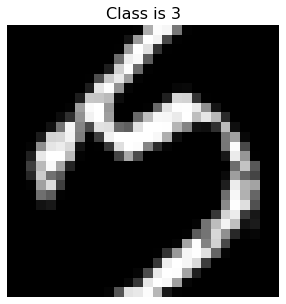

In [125]:
plt.rcParams["figure.figsize"] = 5, 5
plt.imshow(trainset[1000][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[1000][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

In [126]:
labels = []
for i in range(len(trainset)):
    labels.append(trainset[i][1])

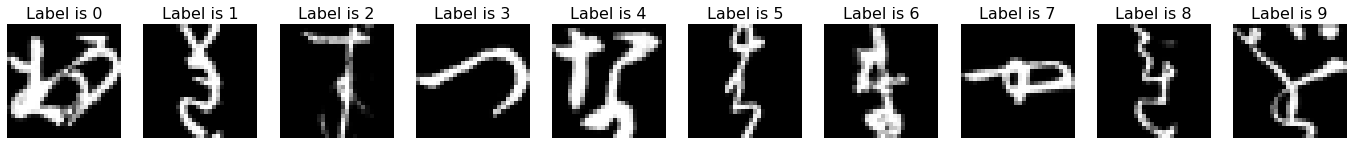

In [127]:
plt.rcParams["figure.figsize"] = 24, 13
k = 0
for i in range(len(labels)):
    if trainset[i][1] == k:
        plt.subplot(1, 10, k+1)
        pixels = trainset[i][0].view(28, 28).numpy()
        plt.imshow(pixels, cmap='gray')
        plt.title(f"Label is {trainset[i][1]}", fontsize=16)
        plt.axis("off")
        k += 1

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [128]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self, activation):
        super().__init__() #  это надо помнить!

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation         

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)
        probs = F.softmax(logits, dim = 1)

        return logits, probs

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** 235146 (234752 - веса, 394 - смещения (количество нейронов))

Тут я немного запуталась: на лекции Лаврентий говорил, что в функцию потерь встроена softmax и поэтому ее не нужно прописывать. Почему мы тогда это делаем? Или, если нам нужна другая функция, мы должны отдельно прописать все функции активации и отдельно softmax для последнего слоя нейронов?

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [129]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [130]:
# Создадим объект модели
fc_net = FCNet(F.relu)
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [131]:
def learning_cycle(n_epochs, trainloader):
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs, _ = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss/len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")        

In [132]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=2.3064
Epoch=2 loss=2.2987
Epoch=3 loss=2.2912
Epoch=4 loss=2.2835
Epoch=5 loss=2.2753
Epoch=6 loss=2.2664
Epoch=7 loss=2.2567
Epoch=8 loss=2.2457
Epoch=9 loss=2.2334
Epoch=10 loss=2.2193
CPU times: user 25.6 s, sys: 2.49 s, total: 28.1 s
Wall time: 1min 15s


In [133]:
get_accuracy(fc_net, testloader)

0.2812

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [134]:
all_pic = []
for i in range(len(trainset)):
    all_pic.extend(trainset[i][0].view(-1, 28*28).tolist()[0])

In [135]:
mean = np.mean(all_pic)
std = np.std(all_pic)
print(mean, std)


0.19176214933278488 0.3483428325349038


In [136]:
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [137]:
fc_net = FCNet(F.relu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

In [138]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=2.2911
Epoch=2 loss=2.2410
Epoch=3 loss=2.1844
Epoch=4 loss=2.1161
Epoch=5 loss=2.0330
Epoch=6 loss=1.9357
Epoch=7 loss=1.8292
Epoch=8 loss=1.7192
Epoch=9 loss=1.6097
Epoch=10 loss=1.5038
CPU times: user 26.5 s, sys: 2.67 s, total: 29.1 s
Wall time: 1min 58s


In [139]:
acc_activation = pd.DataFrame(columns=['Activation_function','Accuracy'])
curr_accuracy = get_accuracy(fc_net, testloader)
acc_activation.loc[len(acc_activation.index)] = ['RELU', curr_accuracy]
curr_accuracy

0.51

Как изменилась `accuracy` после нормализации?

**Ответ:** Accuracy после нормализации несколько увеличилась, хотя всё еще остается низкой. Я понимаю, можно было воспользоваться методами для работы с тензорами, чтобы посчитать `std` и `mean` для нашего одного канала для всех картинок. Но, если я правильно понимаю, мне нужен тензор с размерностью (60000, 1, 28, 28). Такое же примерно, как и в примере на семинаре. Но я пока не понимаю, как его создать. Можно ли создать "пустой" с 4-мя размерностями и найти какой-нибудь аналог `append`, но для тензоров?

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

**Sigmoid**

In [140]:
fc_net = FCNet(nn.Sigmoid())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

In [141]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=2.3267
Epoch=2 loss=2.3073
Epoch=3 loss=2.3017
Epoch=4 loss=2.2996
Epoch=5 loss=2.2982
Epoch=6 loss=2.2971
Epoch=7 loss=2.2960
Epoch=8 loss=2.2949
Epoch=9 loss=2.2938
Epoch=10 loss=2.2927
CPU times: user 26.3 s, sys: 2.69 s, total: 29 s
Wall time: 1min 51s


In [142]:
curr_accuracy = get_accuracy(fc_net, testloader)
acc_activation.loc[len(acc_activation.index)] = ['Sigmoid', curr_accuracy]
curr_accuracy

0.2701

**GELU**

In [143]:
fc_net = FCNet(F.gelu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

In [144]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=2.2828
Epoch=2 loss=2.2567
Epoch=3 loss=2.2285
Epoch=4 loss=2.1961
Epoch=5 loss=2.1572
Epoch=6 loss=2.1090
Epoch=7 loss=2.0487
Epoch=8 loss=1.9741
Epoch=9 loss=1.8864
Epoch=10 loss=1.7894
CPU times: user 27.7 s, sys: 2.58 s, total: 30.3 s
Wall time: 1min 51s


In [145]:
curr_accuracy = get_accuracy(fc_net, testloader)
acc_activation.loc[len(acc_activation.index)] = ['GELU', curr_accuracy]
curr_accuracy

0.43

**Tanh**

In [146]:
fc_net = FCNet(nn.Tanh())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

In [147]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=2.1925
Epoch=2 loss=2.0236
Epoch=3 loss=1.8734
Epoch=4 loss=1.7397
Epoch=5 loss=1.6221
Epoch=6 loss=1.5188
Epoch=7 loss=1.4287
Epoch=8 loss=1.3485
Epoch=9 loss=1.2776
Epoch=10 loss=1.2152
CPU times: user 26.4 s, sys: 2.62 s, total: 29 s
Wall time: 1min 49s


In [148]:
curr_accuracy = get_accuracy(fc_net, testloader)
acc_activation.loc[len(acc_activation.index)] = ['Tanh', curr_accuracy]
acc_optimizer = pd.DataFrame(columns=['Optimizer','Accuracy'])
acc_optimizer.loc[len(acc_optimizer.index)] = ['SGD', curr_accuracy]
acc_activation

,Activation_function,Accuracy
0,RELU,0.5100
1,Sigmoid,0.2701
2,GELU,0.4300
3,Tanh,0.5443


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

**Ответ:** Наибольшее значение `accuracy` удалось достичь при использовании гиперболического тангенса.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

**Adam**

In [149]:
fc_net = FCNet(nn.Tanh())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

In [150]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=0.5109
Epoch=2 loss=0.2005
Epoch=3 loss=0.1179
Epoch=4 loss=0.0740
Epoch=5 loss=0.0435
Epoch=6 loss=0.0269
Epoch=7 loss=0.0159
Epoch=8 loss=0.0110
Epoch=9 loss=0.0042
Epoch=10 loss=0.0023
CPU times: user 30.7 s, sys: 2.83 s, total: 33.6 s
Wall time: 1min 52s


In [151]:
curr_accuracy = get_accuracy(fc_net, testloader)
acc_optimizer.loc[len(acc_optimizer.index)] = ['Adam', curr_accuracy]
curr_accuracy

0.9031

**RMSprop**

In [152]:
fc_net = FCNet(nn.Tanh())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=lr)

In [153]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=0.4333
Epoch=2 loss=0.1871
Epoch=3 loss=0.1155
Epoch=4 loss=0.0761
Epoch=5 loss=0.0490
Epoch=6 loss=0.0412
Epoch=7 loss=0.0288
Epoch=8 loss=0.0236
Epoch=9 loss=0.0257
Epoch=10 loss=0.0156
CPU times: user 28.9 s, sys: 2.75 s, total: 31.7 s
Wall time: 1min 52s


In [154]:
curr_accuracy = get_accuracy(fc_net, testloader)
acc_optimizer.loc[len(acc_optimizer.index)] = ['RMSprop', curr_accuracy]
curr_accuracy

0.8882

**Adagrad**

In [155]:
fc_net = FCNet(nn.Tanh())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=lr)

In [156]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=0.8742
Epoch=2 loss=0.6072
Epoch=3 loss=0.5399
Epoch=4 loss=0.4962
Epoch=5 loss=0.4638
Epoch=6 loss=0.4375
Epoch=7 loss=0.4157
Epoch=8 loss=0.3970
Epoch=9 loss=0.3797
Epoch=10 loss=0.3649
CPU times: user 28.9 s, sys: 2.79 s, total: 31.7 s
Wall time: 1min 58s


In [157]:
curr_accuracy = get_accuracy(fc_net, testloader)
acc_optimizer.loc[len(acc_optimizer.index)] = ['Adagrad', curr_accuracy]
acc_optimizer

,Optimizer,Accuracy
0,SGD,0.5443
1,Adam,0.9031
2,RMSprop,0.8882
3,Adagrad,0.7787


**Ответ:** С выбранной функцией активации (*Tanh*) наибольшее значение `accuracy` было достигнуто при использовании в качестве оптимизатора *Adam*

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [158]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x[x < 0] = 0
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [159]:
fc_net = FCNet(CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

In [160]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=0.4519
Epoch=2 loss=0.1875
Epoch=3 loss=0.1212
Epoch=4 loss=0.0839
Epoch=5 loss=0.0581
Epoch=6 loss=0.0379
Epoch=7 loss=0.0296
Epoch=8 loss=0.0198
Epoch=9 loss=0.0179
Epoch=10 loss=0.0138
CPU times: user 33.3 s, sys: 2.76 s, total: 36 s
Wall time: 1min 52s


In [161]:
get_accuracy(fc_net, testloader)

0.8983

In [162]:
fc_net = FCNet(F.relu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

In [163]:
%%time
learning_cycle(10, trainloader)

Epoch=1 loss=0.4493
Epoch=2 loss=0.1862
Epoch=3 loss=0.1182
Epoch=4 loss=0.0846
Epoch=5 loss=0.0566
Epoch=6 loss=0.0394
Epoch=7 loss=0.0325
Epoch=8 loss=0.0215
Epoch=9 loss=0.0146
Epoch=10 loss=0.0088
CPU times: user 29.6 s, sys: 2.81 s, total: 32.4 s
Wall time: 1min 50s


In [164]:
get_accuracy(fc_net, testloader)

0.8961

**Ответ:** Всё-таки мне кажется, `accuracy` несколько отличаются с ReLU и CustomRelu.

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

По запросам:\
1) "Самый милый щенок на свете"\
2) "я грустила у окна, потому что там война"\
3) "новая жизнь"\
4) "Эрен превращается в титана"\
5) "любовь спасет мир"\
6) "милые коровки на альпийских лугах"

<img src='https://drive.google.com/uc?id=1hvvNKBZWpgtx-_r9rZJeHdNpGOYj7wDW' width="330" height="330">  <img src='https://drive.google.com/uc?id=1gvTY1NxCp74NofIOVwK1rmovNoUu6EDz' width="330" height="330">  <img src='https://drive.google.com/uc?id=12lTxPp2CXZo1t_xNUhhkirAoAUcksG03' width="330" height="330">  <img src='https://drive.google.com/uc?id=1py7fjbYFtOShK3ptzE2X-34r7YPTa7yH' width="330" height="330">  <img src='https://drive.google.com/uc?id=1Nma67HlmobXCWkU-3US3Ss4xBueQAsWg' width="330" height="330">  <img src='https://drive.google.com/uc?id=1jq2GB9gAj_brt1pMivUkAgV38YueDev4' width="330" height="330">

ruDALL-E еще и эмодзи может создавать O_o:

По запросам:\
1) "нейронные сети"\
2) "радость от сделанной домашки" (мой фаворит - эмодзи с индексом [2, 1])

<img src='https://drive.google.com/uc?id=10Et1SXFgft_XizOT0oDP7Z2H9IsHY57g' width="500" height="500">______<img src='https://drive.google.com/uc?id=1K1IkTbatKn_hdPqoBzt-fRiggBy1kBow' width="500" height="500">




слишком залипательное задание :)